<a href="https://colab.research.google.com/github/sana-abboud/Diamond-Price-Prediction/blob/main/Diamond_EDA_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'diamond-price-prediciton-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77458%2F8457230%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T181913Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7b4061fb1fd7f177d288c6f9c53579ca1f0920bb5343054a850f7bb49bd97c200ad01dc973405ed18eb341b1f82a6d50389abbd4c825154091880bc1aa88ce7e32461b12970404e1e5d9201e87ac52fbff3e93373881cef35a8775d68441960cc1f77427e83f2175a25565ee3550ba0ca184ca71e3d995c879b00e08beffc2eecd019fe4ab192948a42d3fa23a65bcd7138fd3e988c495965ee5b1cc2897f0e96155025e661a061bed17a90d0afc6529600aef927edef070dc17b1bd03ce9c87e5d1ddbecfbb6d5de52afd94ba972f43a35a6e0dd521a39af56f30837bb74323788407fcf0f437db9bcdf74b415a674ec6c1a8ca3902ed52f1d20aec74eb7743'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# DS life cycle project
- understand the problem
- get data
- check data
- EDA
- Data preprocessing
- Model Training
- chose the model





##Data Checks to perform
-	Check Missing values
-	Check Duplicates
-	Check data type
-	Check the number of unique values of each column
-	Check statistics of data set
-	Check various categories present in the different categorical column

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [ ]:
train_df = pd.read_csv('/kaggle/input/diamond-price-prediciton-2024/train.csv')

train_df

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50
...,...,...,...,...,...,...,...,...,...,...,...
43147,43148,0.52,Ideal,E,VS2,61.5,56.0,1760,5.16,5.18,3.18
43148,43149,0.72,Very Good,D,VS2,62.1,59.0,3016,5.70,5.73,3.55
43149,43150,0.44,Premium,I,VVS1,61.5,58.0,990,4.95,4.87,3.02
43150,43151,0.31,Premium,E,VS1,60.2,58.0,734,4.38,4.43,2.65


In [ ]:
train_df.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [ ]:
train_df.describe()

,Id,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,21576.500000,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,12457.053745,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10788.750000,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,21576.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,32364.250000,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,43152.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [ ]:
train_df.duplicated().sum()

0

In [ ]:
train_df.shape

(43152, 11)

In [ ]:
train_df.size

474672

In [ ]:
len(train_df['carat'])

43152

In [ ]:
train_df.columns

Index(['Id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price',
       'x', 'y', 'z'],
      dtype='object')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [ ]:
# Splitting categorical and numerical columns
categorical_columns = train_df.select_dtypes(include=['object']).columns
numerical_columns = train_df.select_dtypes(include=['int', 'float']).columns

In [ ]:
categorical_columns

Index(['cut', 'color', 'clarity'], dtype='object')

In [ ]:
for i in categorical_columns:
  print(i)
  print(train_df[i].unique())
  print(train_df[i].nunique())
  print()
  print(train_df[i].value_counts())
  print()

cut
['Ideal' 'Premium' 'Very Good' 'Fair' 'Good']
5

cut
Ideal        17203
Premium      11113
Very Good     9658
Good          3881
Fair          1297
Name: count, dtype: int64

color
['I' 'G' 'F' 'H' 'D' 'E' 'J']
7

color
G    9060
E    7832
F    7633
H    6651
D    5421
I    4265
J    2290
Name: count, dtype: int64

clarity
['SI2' 'VVS2' 'VS2' 'IF' 'VS1' 'SI1' 'VVS1' 'I1']
8

clarity
SI1     10428
VS2      9824
SI2      7432
VS1      6475
VVS2     4041
VVS1     2904
IF       1442
I1        606
Name: count, dtype: int64



In [ ]:
df_missing = pd.read_csv("/kaggle/input/diamond-price-prediciton-2024/train.csv")
df_missing

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50
...,...,...,...,...,...,...,...,...,...,...,...
43147,43148,0.52,Ideal,E,VS2,61.5,56.0,1760,5.16,5.18,3.18
43148,43149,0.72,Very Good,D,VS2,62.1,59.0,3016,5.70,5.73,3.55
43149,43150,0.44,Premium,I,VVS1,61.5,58.0,990,4.95,4.87,3.02
43150,43151,0.31,Premium,E,VS1,60.2,58.0,734,4.38,4.43,2.65


In [ ]:
df_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [ ]:
df_missing.isnull().sum()

Id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

# Plots
Numarical

1) line plot -> between two features

2) scatter plot -> correlation

2*) Bubble -> correlation for multi D

3) histgram

4) boxplot

Categorical

1) pie

2) bar plot

3) boxplot


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
numerical_columns

Index(['Id', 'carat', 'depth', 'table', 'price', 'x', 'y', 'z'], dtype='object')

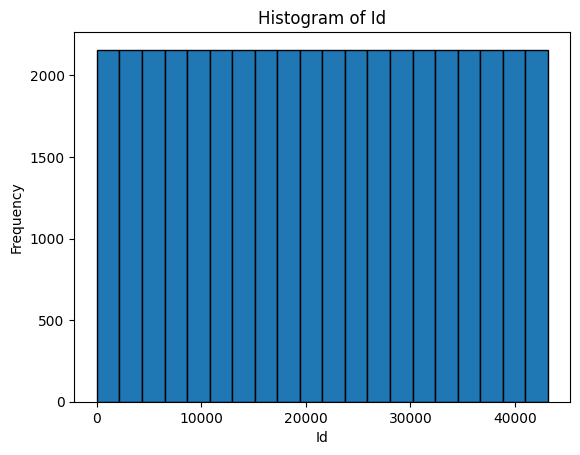

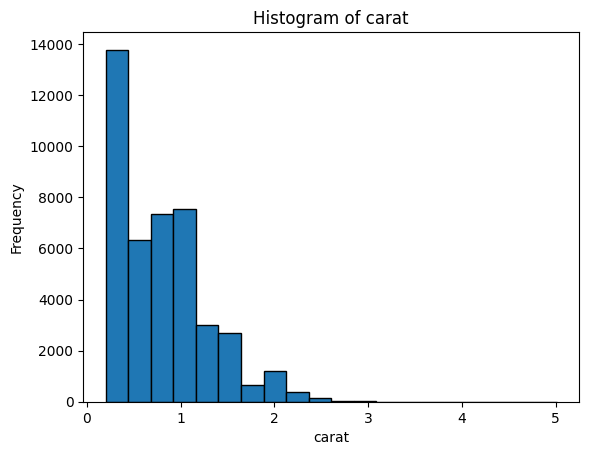

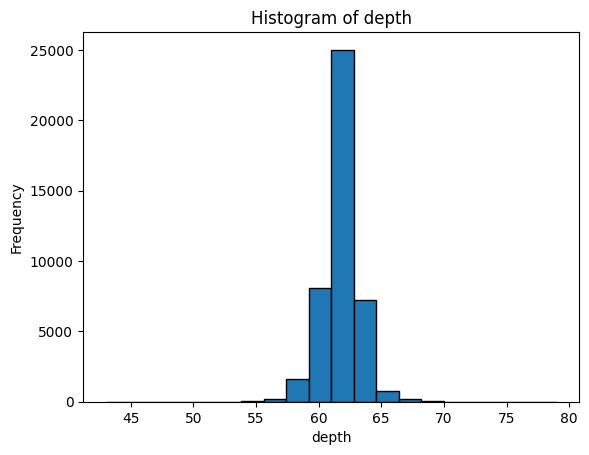

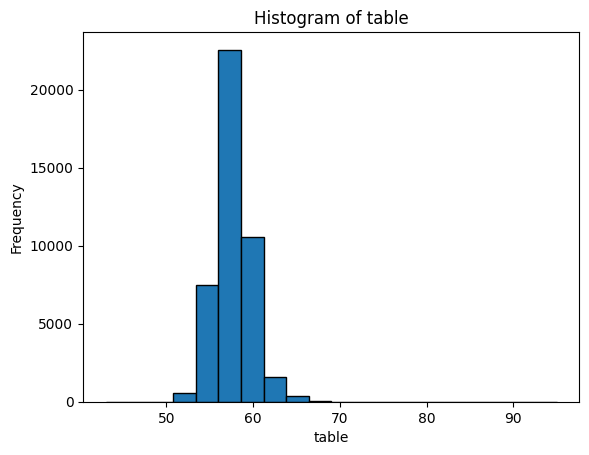

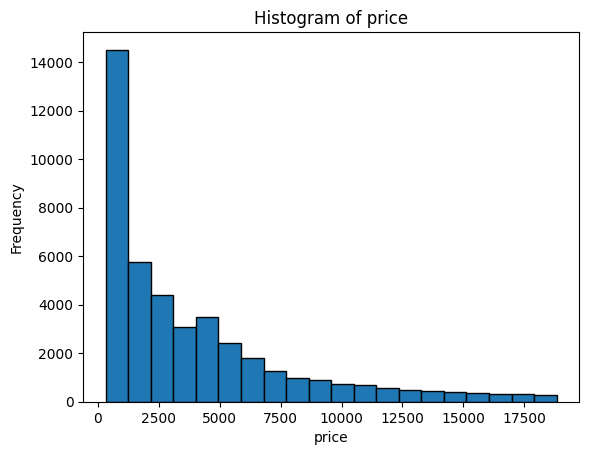

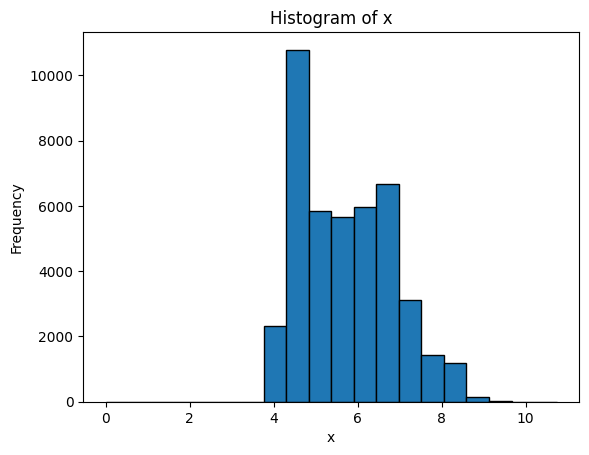

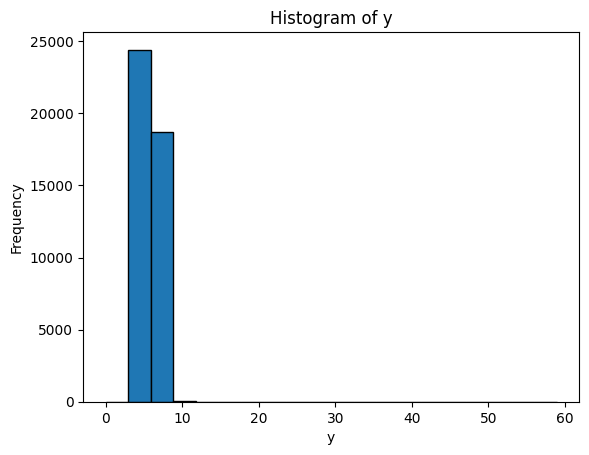

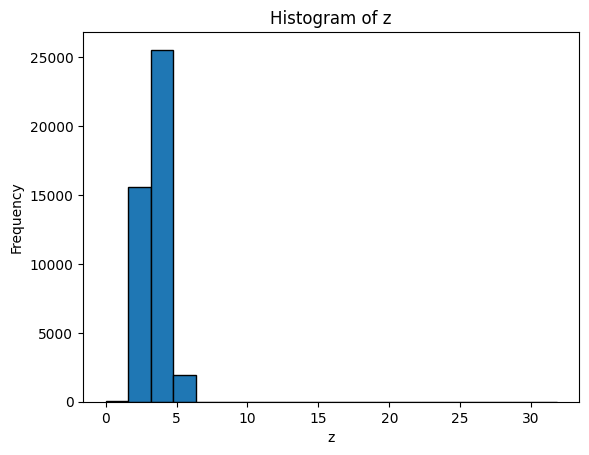

In [ ]:
for i in numerical_columns:
  plt.hist(train_df[i], bins=20, edgecolor='black')

  # Adding labels and title
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.title(f'Histogram of {i}')

  # Display the histogram
  plt.show()

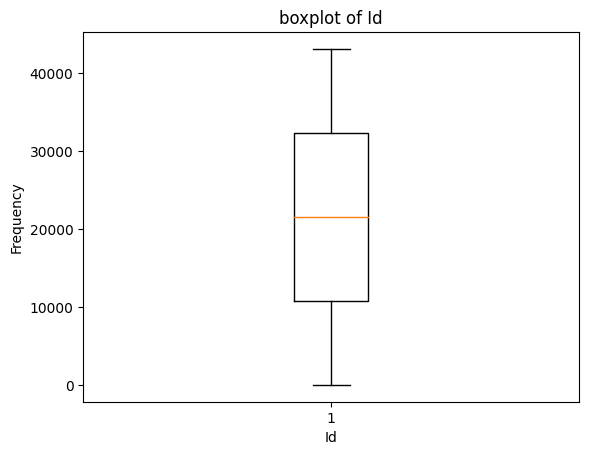

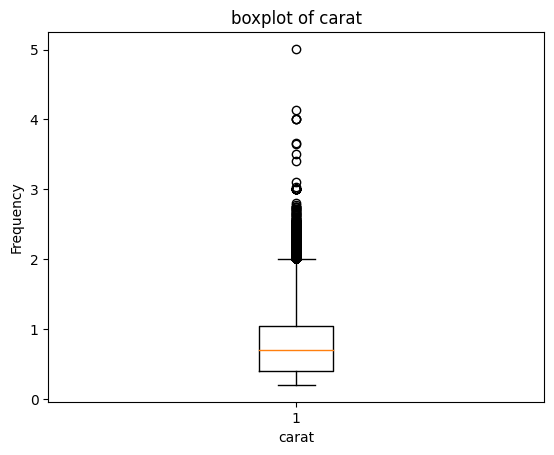

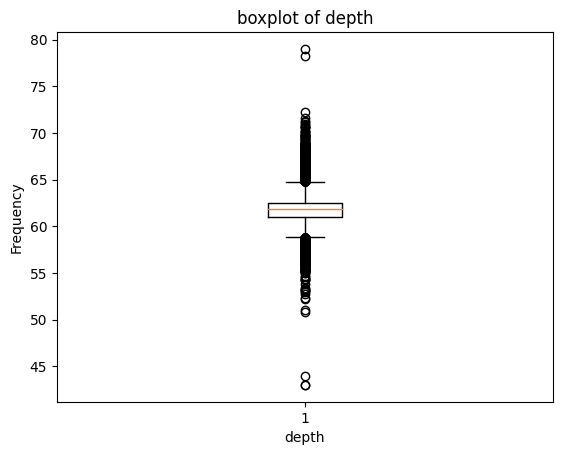

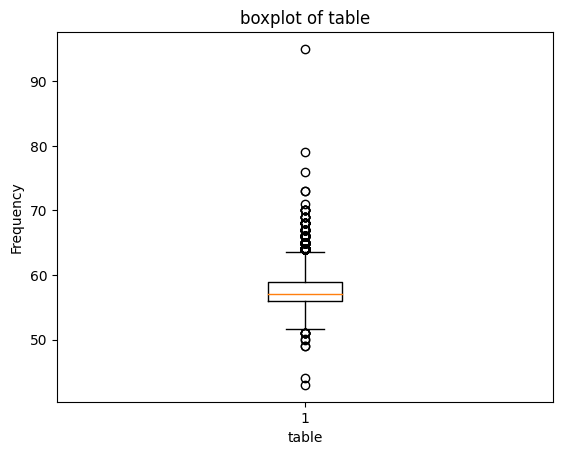

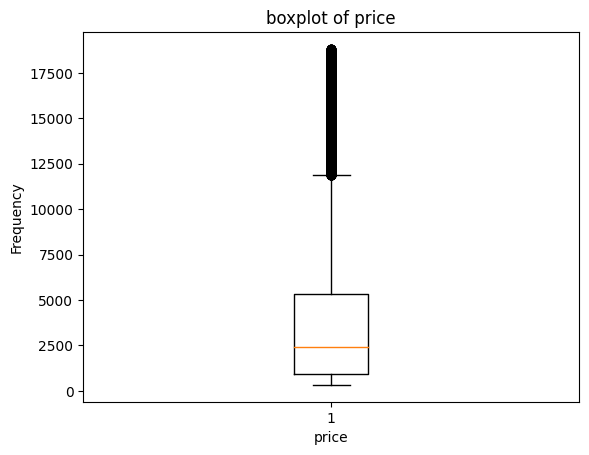

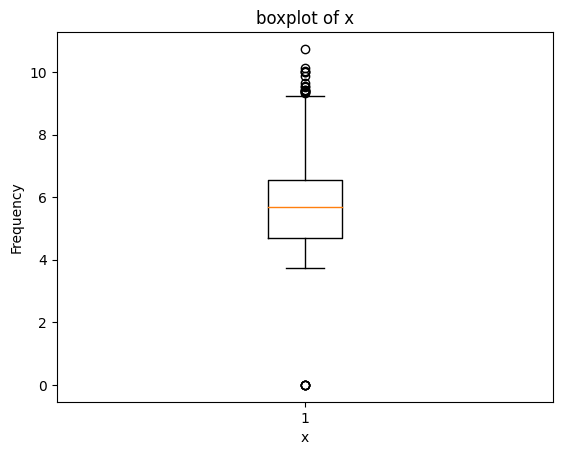

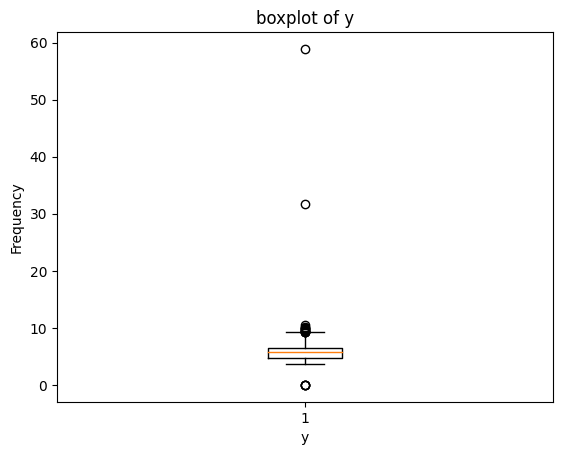

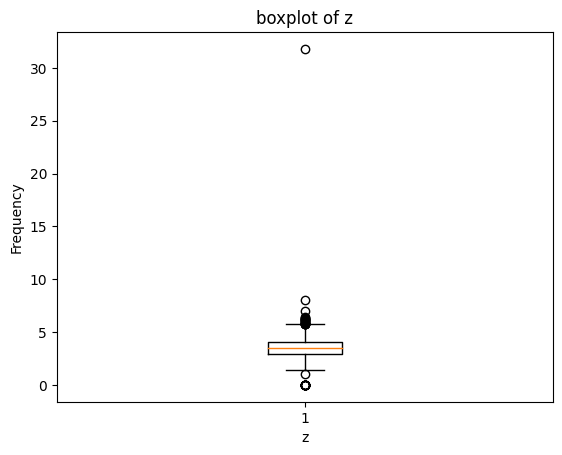

In [ ]:
# outliers check

for i in numerical_columns:
  plt.boxplot(train_df[i])

  # Adding labels and title
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.title(f'boxplot of {i}')

  # Display the histogram
  plt.show()

In [ ]:
train_df['price'].describe()

count    43152.000000
mean      3929.491912
std       3985.527795
min        326.000000
25%        947.750000
50%       2401.000000
75%       5312.000000
max      18823.000000
Name: price, dtype: float64

In [ ]:
train_df_encoded = pd.get_dummies(train_df)

# Calculate correlation
correlation_matrix = train_df_encoded.corr()
print(correlation_matrix)

                     Id     carat     depth     table     price         x  \
Id             1.000000  0.001141 -0.000776 -0.000739 -0.001111 -0.000519   
carat          0.001141  1.000000  0.023944  0.182889  0.921911  0.975760   
depth         -0.000776  0.023944  1.000000 -0.302794 -0.013137 -0.029601   
table         -0.000739  0.182889 -0.302794  1.000000  0.128501  0.197342   
price         -0.001111  0.921911 -0.013137  0.128501  1.000000  0.885181   
x             -0.000519  0.975760 -0.029601  0.197342  0.885181  1.000000   
y              0.001660  0.947060 -0.033354  0.184310  0.861354  0.968954   
z             -0.000981  0.948923  0.090834  0.150746  0.857665  0.965677   
cut_Fair       0.003998  0.091132  0.275564  0.120999  0.018997  0.080786   
cut_Good       0.003570  0.034602  0.137057  0.171198  0.000015  0.031697   
cut_Ideal     -0.003327 -0.167548 -0.019140 -0.551698 -0.101182 -0.167386   
cut_Premium   -0.001600  0.118258 -0.200840  0.341498  0.097585  0.129190   

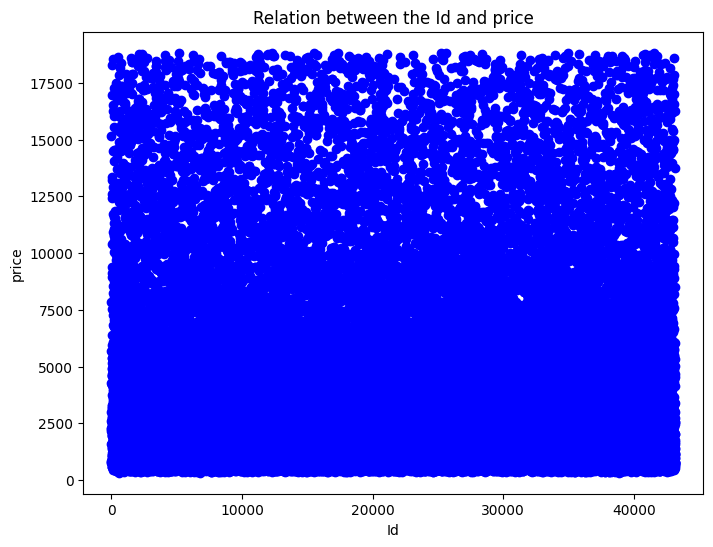

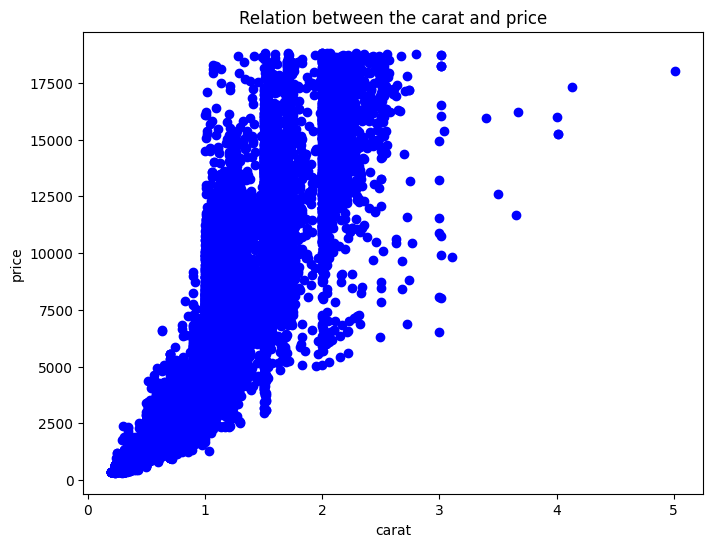

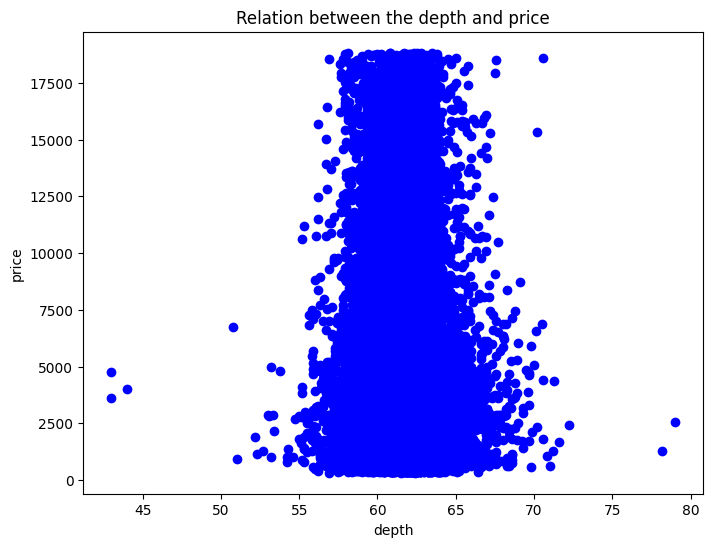

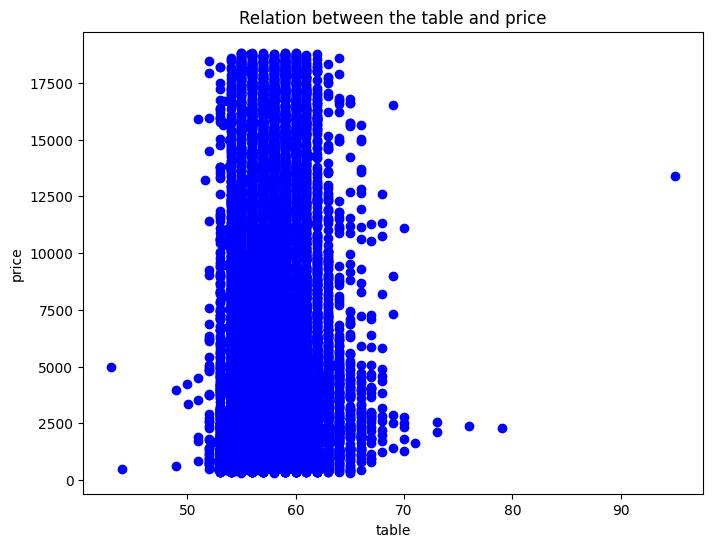

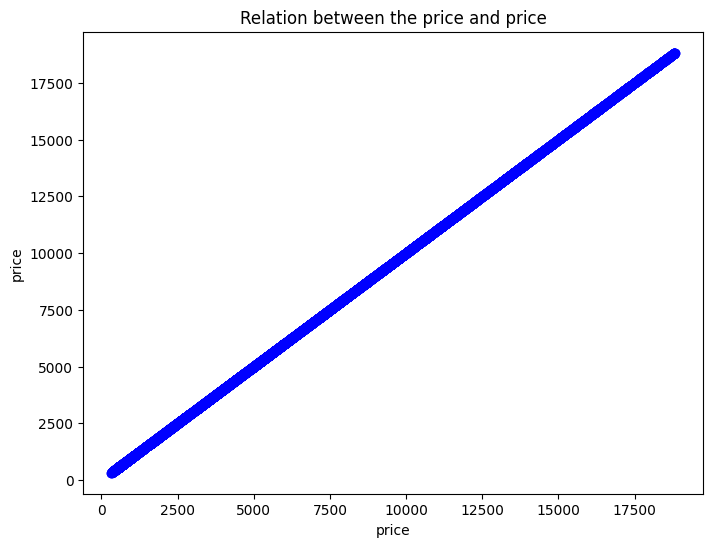

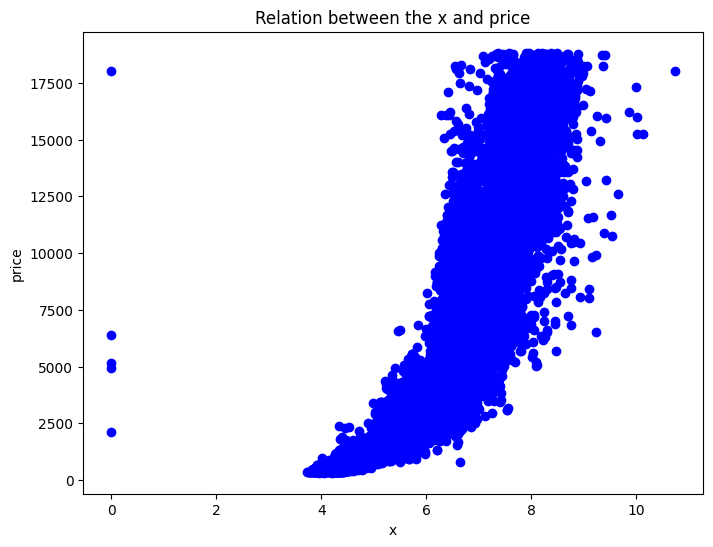

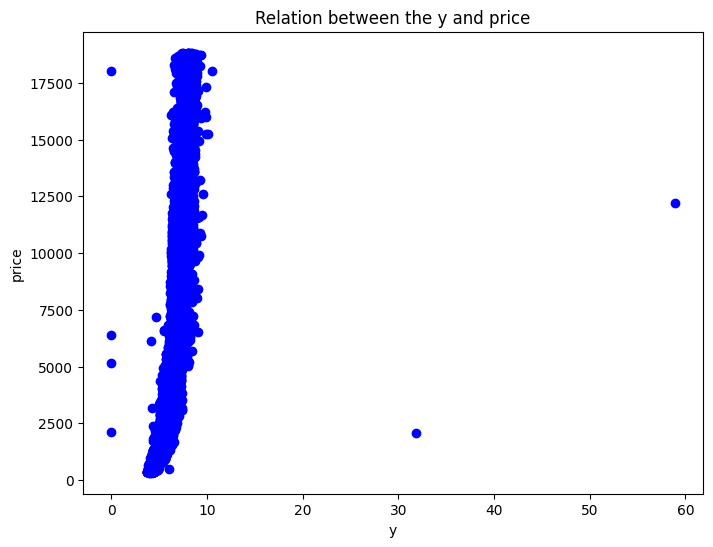

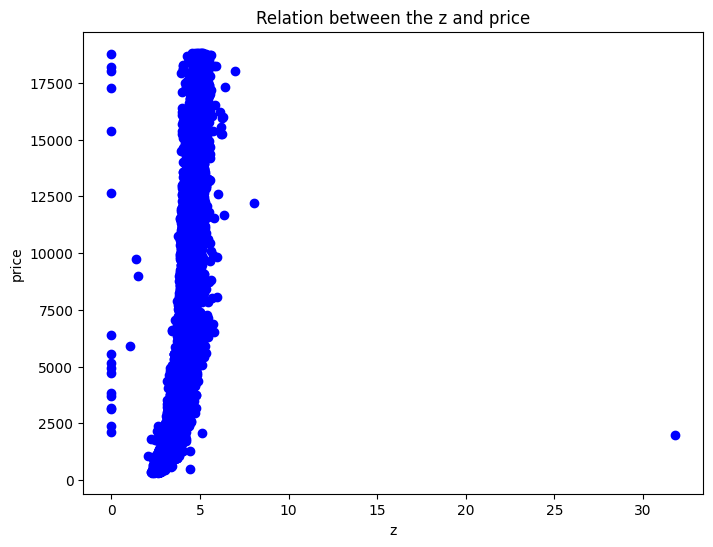

In [ ]:
# Features with target

for i in numerical_columns:
  plt.figure(figsize=(8, 6))
  plt.scatter(train_df[i], train_df['price'], c='blue', marker='o')

  # Adding labels and title
  plt.xlabel(i)
  plt.ylabel('price')
  plt.title(f'Relation between the {i} and price')

  # Display the scatter plot
  plt.show()

In [ ]:
train_df[['carat','price']]

,carat,price
0,1.06,4270
1,1.51,15164
2,0.32,828
3,0.53,1577
4,0.70,2596
...,...,...
43147,0.52,1760
43148,0.72,3016
43149,0.44,990
43150,0.31,734


In [ ]:
# categorical_columns
categorical_columns

Index(['cut', 'color', 'clarity'], dtype='object')

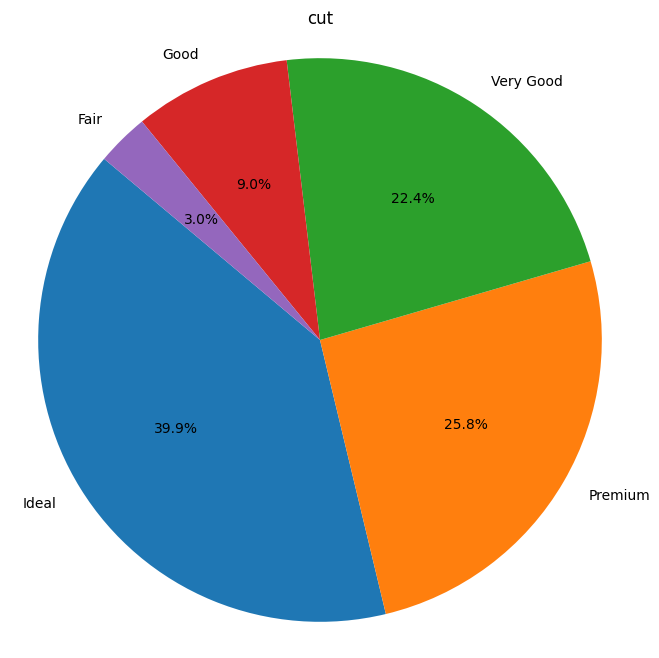

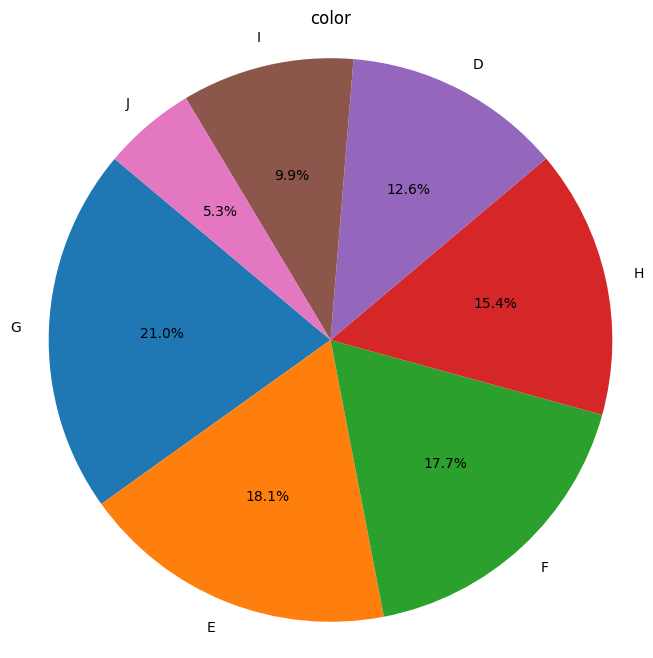

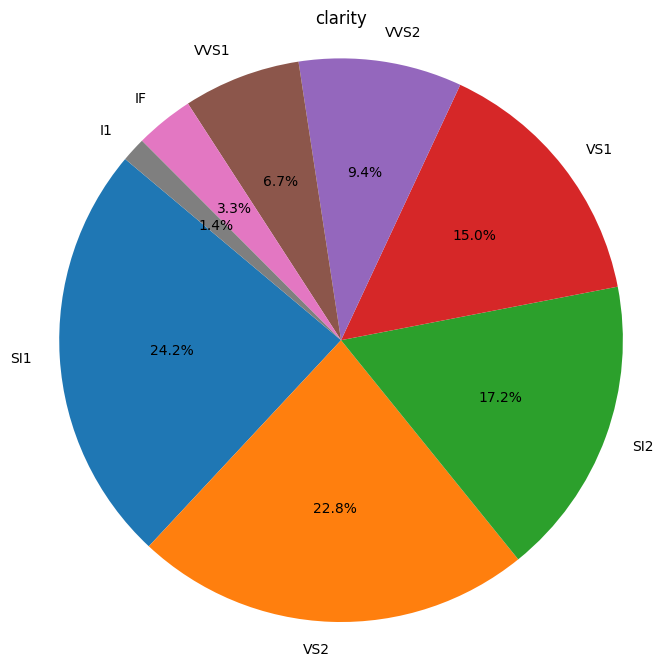

In [ ]:
for i in categorical_columns:

  cut_counts = train_df[i].value_counts()

  # Create a pie plot
  plt.figure(figsize=(8, 8))
  plt.pie(cut_counts, labels=cut_counts.index, autopct='%1.1f%%', startangle=140)

  # Equal aspect ratio ensures that pie is drawn as a circle.'
  plt.axis('equal')

  # Adding a title
  plt.title(i)

  # Display the pie plot
  plt.show()

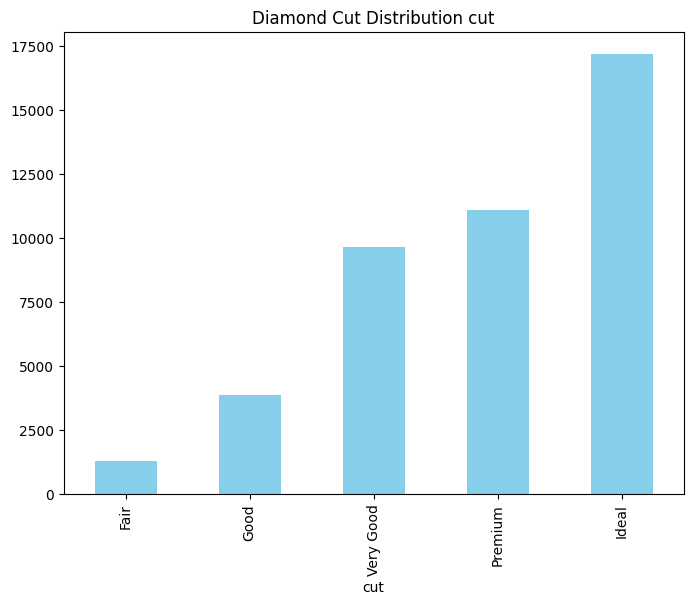

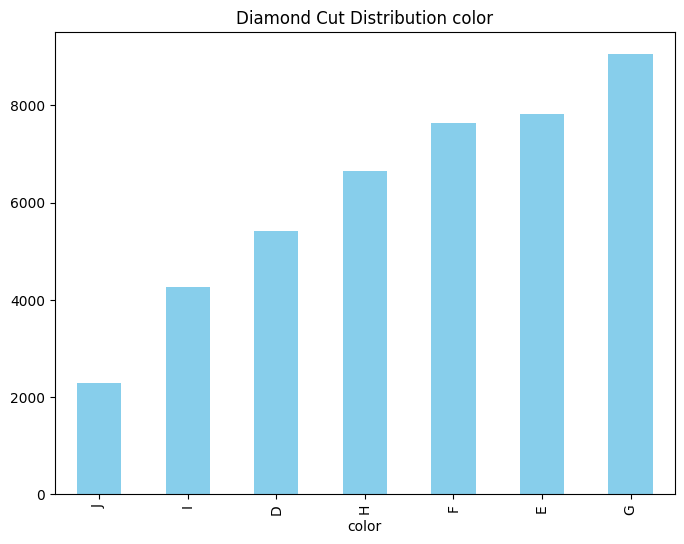

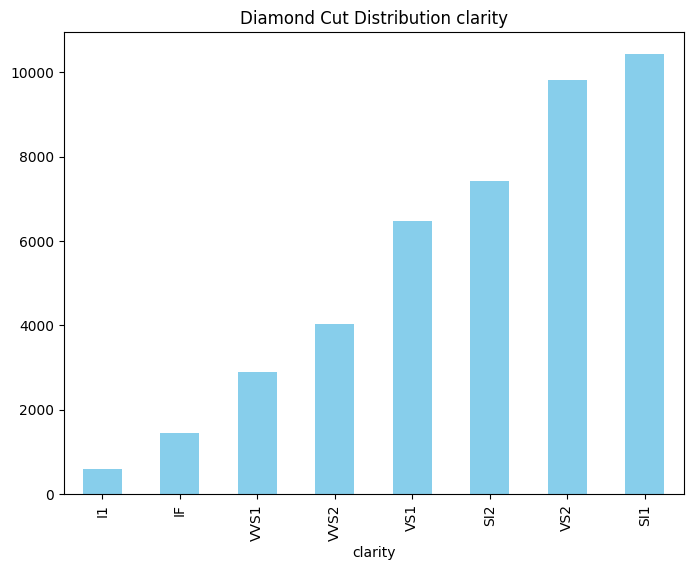

In [ ]:
for i in categorical_columns:

  cut_counts = train_df[i].value_counts()

  # Sort the cut counts in descending order
  cut_counts_sorted = cut_counts.sort_values(ascending=True)

  # Create a bar plot
  plt.figure(figsize=(8, 6))
  cut_counts_sorted.plot(kind='bar', color='skyblue')

  # Adding labels and title
  plt.title(f'Diamond Cut Distribution {i}')

  # Display the bar plot
  plt.show()

In [ ]:
train_df['color'].unique()

array(['I', 'G', 'F', 'H', 'D', 'E', 'J'], dtype=object)

In [ ]:
train_df[train_df['color']=='I']

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
13,14,0.33,Premium,I,VS2,60.6,58.0,594,4.47,4.44,2.70
28,29,0.42,Ideal,I,VVS1,60.2,57.0,945,4.88,4.85,2.93
43,44,0.34,Ideal,I,SI1,61.9,57.0,589,4.52,4.49,2.79
44,45,1.51,Very Good,I,VS2,63.0,60.0,8952,7.25,7.30,4.58
...,...,...,...,...,...,...,...,...,...,...,...
43112,43113,1.00,Very Good,I,VS1,63.3,55.0,4516,6.39,6.34,4.03
43118,43119,0.42,Ideal,I,VS1,61.5,56.0,771,4.83,4.86,2.98
43130,43131,0.43,Ideal,I,VVS1,62.2,57.0,968,4.84,4.81,3.00
43138,43139,2.26,Premium,I,SI2,62.0,58.0,16241,8.40,8.37,5.20


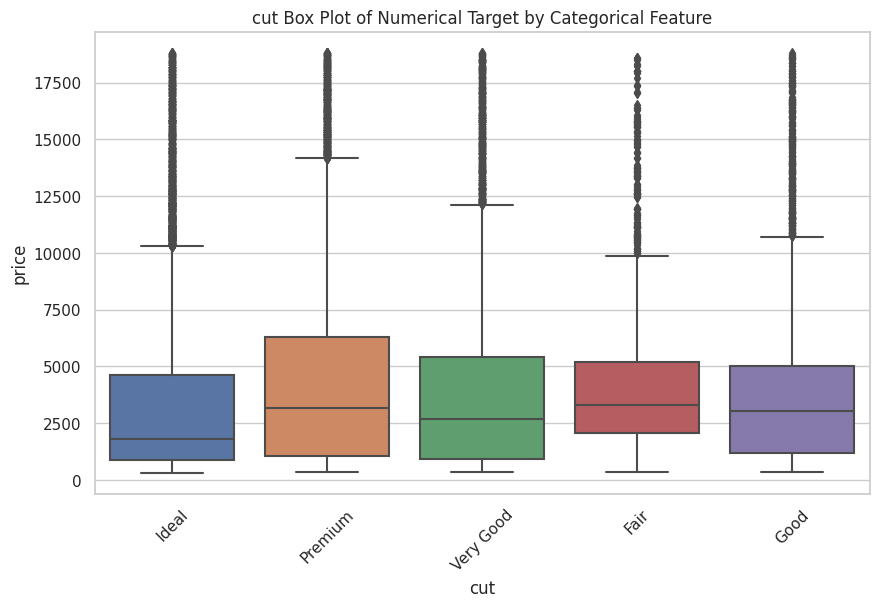

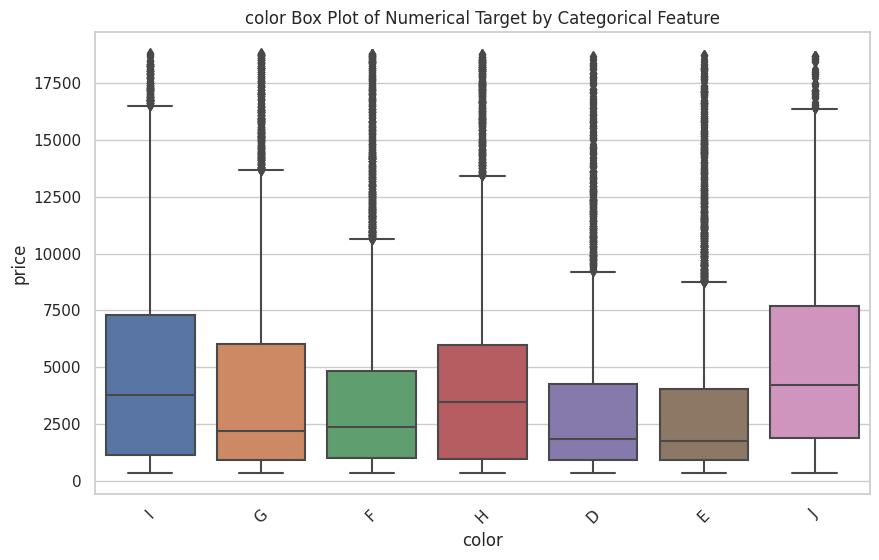

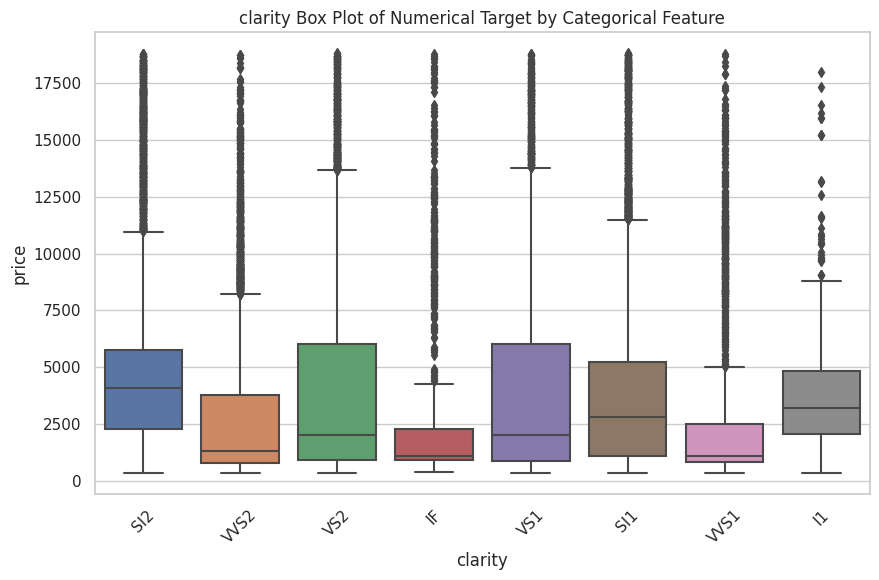

In [ ]:
for i in categorical_columns:
  sns.set(style="whitegrid")
  plt.figure(figsize=(10, 6))
  sns.boxplot(x=i, y="price", data=train_df)
  plt.title(f"{i} Box Plot of Numerical Target by Categorical Feature")
  plt.xticks(rotation=45)
  plt.show()


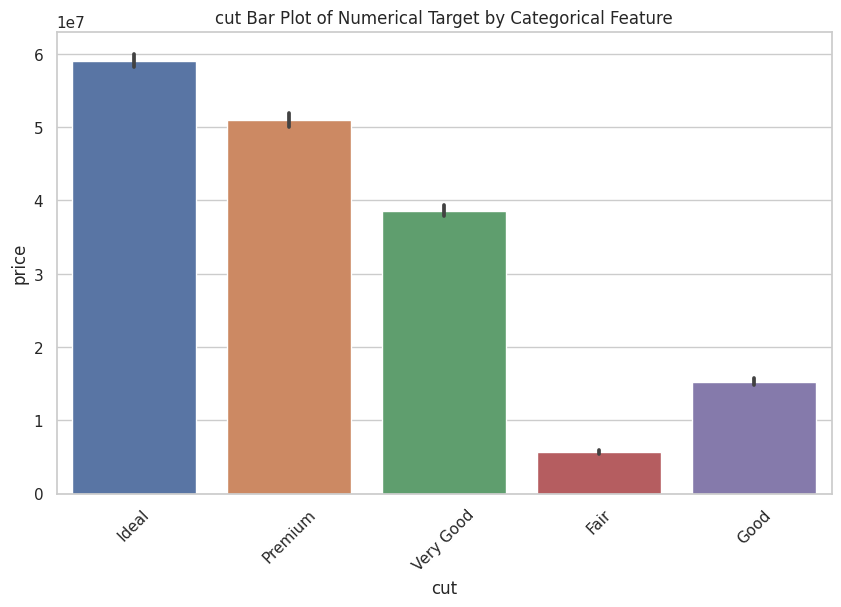

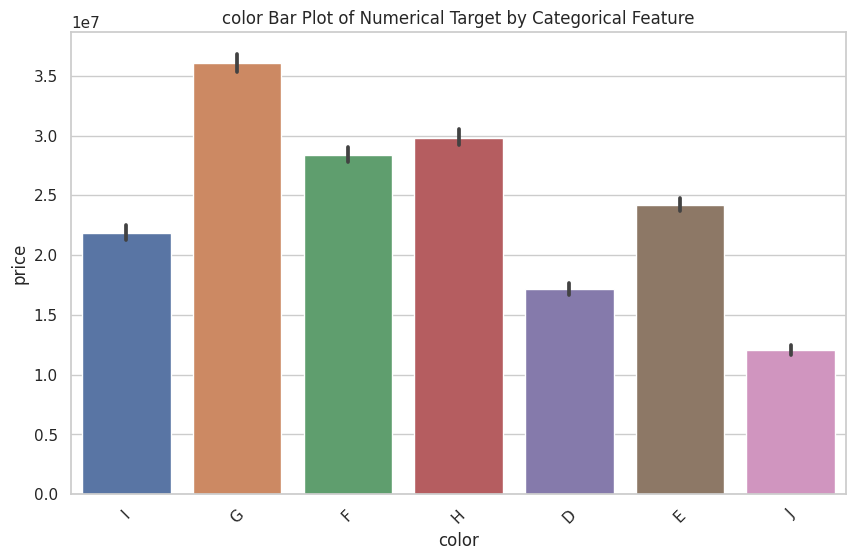

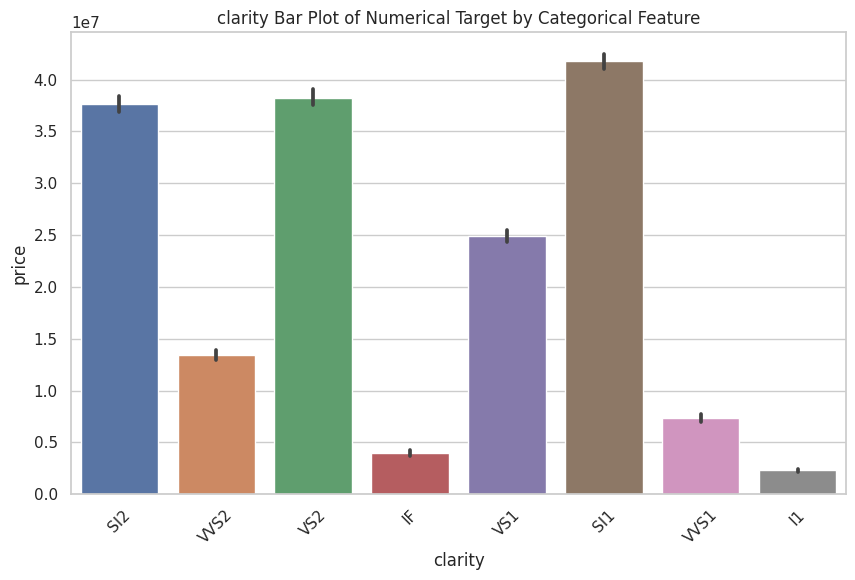

In [ ]:
for i in categorical_columns:
  plt.figure(figsize=(10, 6))
  sns.barplot(x=i, y="price", data=train_df, estimator=sum)
  plt.title(f"{i} Bar Plot of Numerical Target by Categorical Feature")
  plt.xticks(rotation=45)
  plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Count the occurrences of each cut category
cut_counts = train_df['cut'].value_counts().reset_index()
cut_counts.columns = ['cut', 'count']

# Create an interactive pie plot using Plotly
fig = px.pie(cut_counts, values='count', names='cut', title='Diamond Cut Distribution')
fig.show()


#Insights from the data

1) cart not normal distrubution -> skewd to the right

2) y and z not normal distrubution

3) there a lot of outliers

4) cart high corr with x,y,z

5) depth weak corr with price

6) Categorical have good relation with target -> but there outliers



In [ ]:
data = pd.read_csv("/kaggle/input/diamond-price-prediciton-2024/train.csv")
data.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [ ]:
data.shape

(43152, 11)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [ ]:
#The first column seems to be just index
data = data.drop(["Id"], axis=1)
data.describe()

,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [ ]:
from scipy.stats import skew

In [ ]:
print("Carat", skew(data["carat"]))
print("depth",skew(data["depth"]))
print("table",skew(data["table"]))
print("x",skew(data["x"]))
print("y", skew(data["y"]))
print("z", skew(data["z"]))

Carat 1.1092284098183531
depth -0.15877301813575728
table 0.8040632435171631
x 0.3808358279550659
y 2.907246830213165
z 1.795332801363756


In [ ]:
data["y"] = np.log1p(data["y"])
print("y", skew(data["y"]))
data["z"] = np.log1p(data["z"])
print("z", skew(data["z"]))
data["carat"] = np.log1p(data["carat"])
print("carat", skew(data["carat"]))

y 0.0757467311631924
z -0.1579895353692754
carat 0.5777444196290503


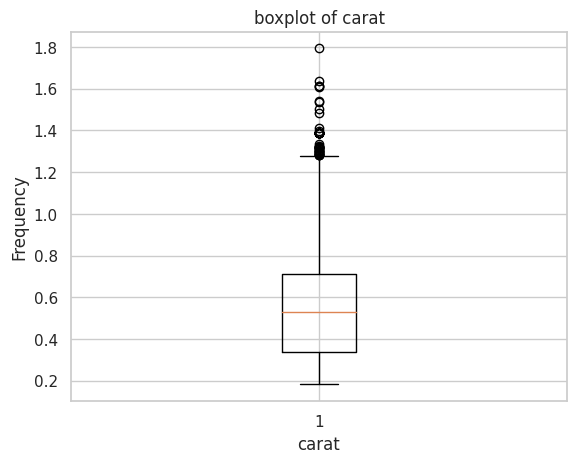

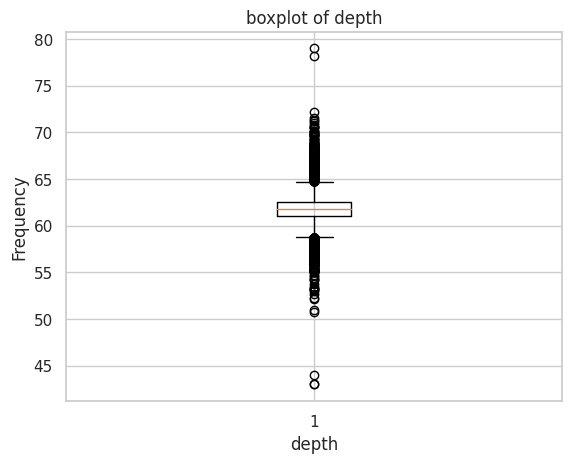

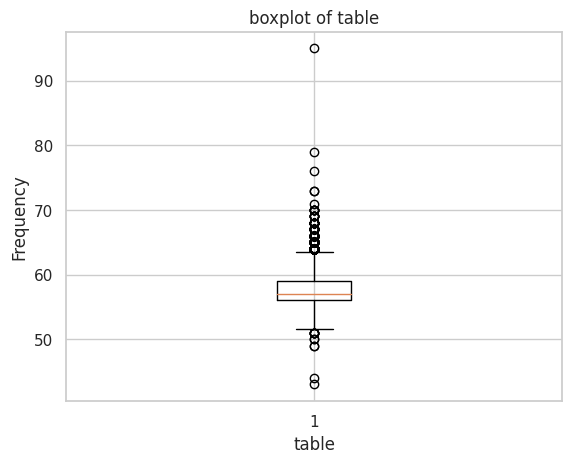

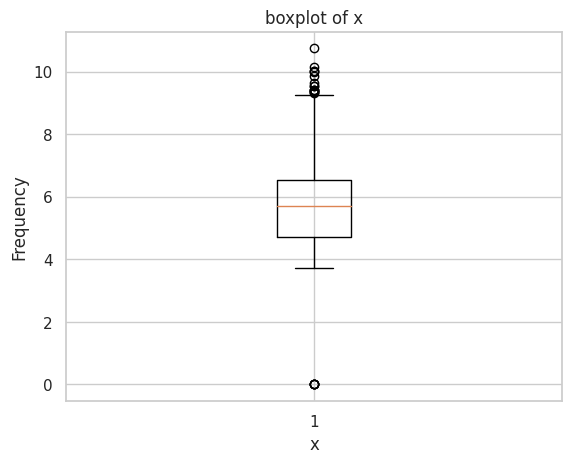

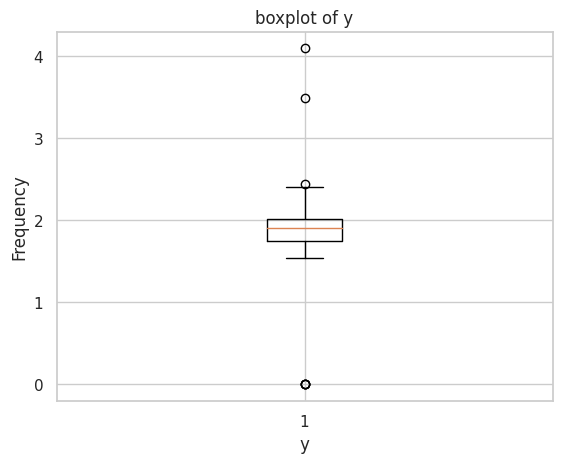

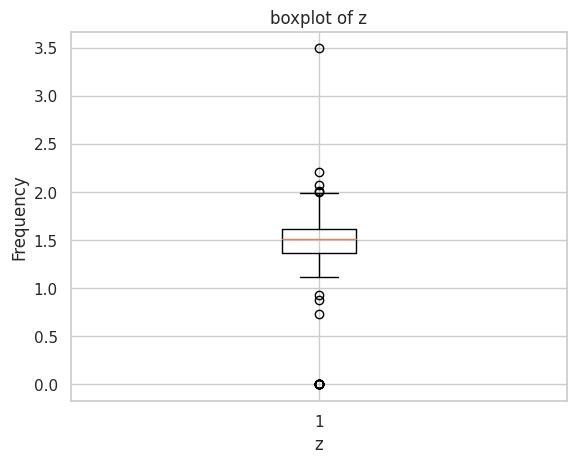

In [ ]:
cols = ["carat", "depth", "table", "x", "y", "z"]
for i in cols:
  plt.boxplot(data[i])

  # Adding labels and title
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.title(f'boxplot of {i}')

  # Display the histogram
  plt.show()

In [ ]:
cols = ["x", "y", "z"]
data[cols] = data[cols].replace(0, np.nan)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43152 non-null  float64
 1   cut      43152 non-null  object 
 2   color    43152 non-null  object 
 3   clarity  43152 non-null  object 
 4   depth    43152 non-null  float64
 5   table    43152 non-null  float64
 6   price    43152 non-null  int64  
 7   x        43147 non-null  float64
 8   y        43148 non-null  float64
 9   z        43135 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.3+ MB


In [ ]:
mean_x = data['x'].mean()
data['x'].fillna(mean_x, inplace=True)

median_y = data['y'].median()
data['y'].fillna(median_y, inplace=True)

median_z = data['z'].median()
data['z'].fillna(median_z, inplace=True)

/tmp/ipykernel_33/3099894391.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_33/3099894391.py:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

In [ ]:
data.describe()

,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,0.555304,61.747177,57.458347,3929.491912,5.732232,1.893797,1.501401
std,0.244781,1.435454,2.233904,3985.527795,1.119580,0.163891,0.150970
min,0.182322,43.000000,43.000000,326.000000,3.730000,1.543298,0.727549
25%,0.336472,61.000000,56.000000,947.750000,4.710000,1.743969,1.363537
50%,0.530628,61.800000,57.000000,2401.000000,5.700000,1.903599,1.510722
75%,0.712950,62.500000,59.000000,5312.000000,6.540000,2.020222,1.617406
max,1.793425,79.000000,95.000000,18823.000000,10.740000,4.092677,3.490429


In [ ]:
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1

    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data

    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR


    outlier_free_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]



for i in cols:
    if i == cols[0]:
      removeOutliers(data, i)
    else:
      removeOutliers(filtered_data, i)


# Assigning filtered data back to our original variable
data = filtered_data
print("Shape of data after outlier removal is: ", data.shape)

IQR value for column x is: 1.83
IQR value for column y is: 0.2762533766281585
IQR value for column z is: 0.2538687080860027
Shape of data after outlier removal is:  (43130, 10)


In [ ]:
# Get list of categorical variables
s = (data.dtypes =="object")
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


In [ ]:
# Make copy to avoid changing original data
label_data = data.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_data[col] = label_encoder.fit_transform(label_data[col])
label_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.722706,2,5,3,61.8,57.0,4270,6.57,2.028148,1.623341
1,0.920283,3,3,7,60.9,58.0,15164,7.38,2.130610,1.706565
2,0.277632,2,2,5,61.3,56.0,828,4.43,1.688249,1.311032
3,0.425268,2,3,5,61.2,56.0,1577,5.19,1.827770,1.432701
4,0.530628,3,4,7,61.0,57.0,2596,5.76,1.905088,1.504077


<Axes: >

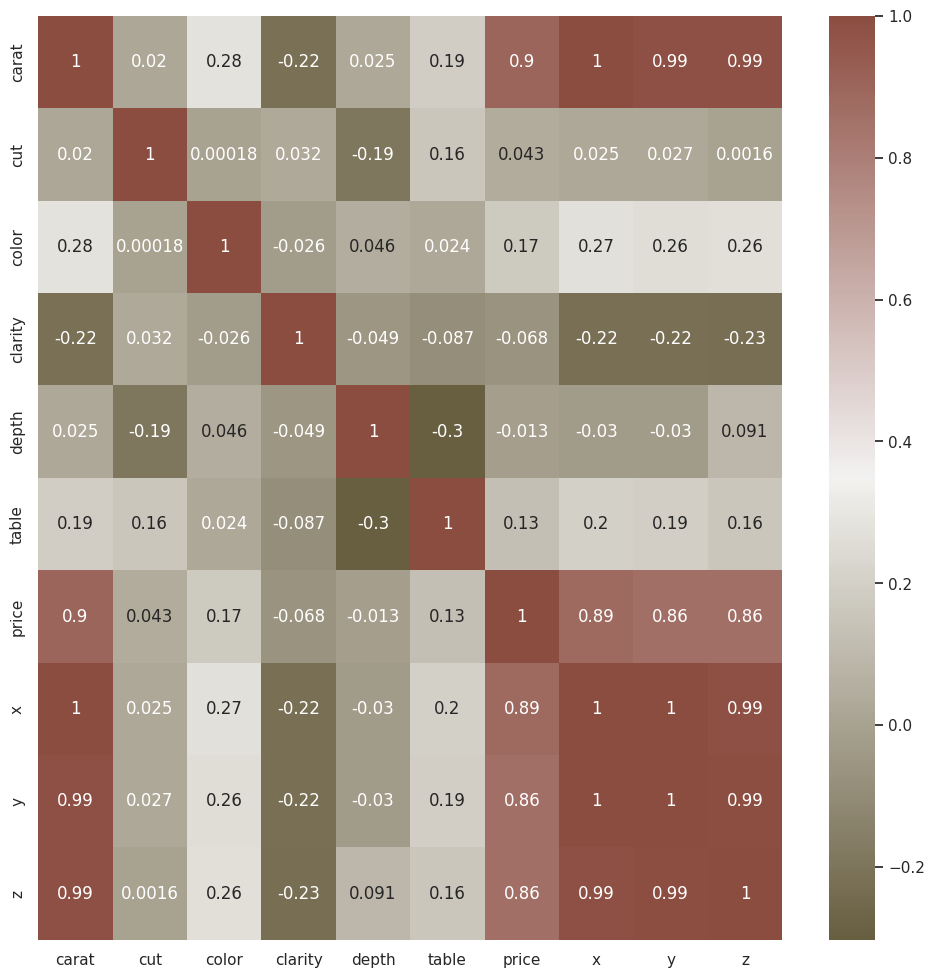

In [ ]:
#correlation matrix
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= label_data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

In [ ]:
data.describe()

,carat,depth,table,price,x,y,z
count,43130.000000,43130.000000,43130.000000,43130.000000,43130.000000,43130.000000,43130.000000
mean,0.554927,61.747266,57.458008,3924.900348,5.730638,1.893523,1.501215
std,0.244122,1.434483,2.233195,3979.874046,1.117104,0.163152,0.150316
min,0.182322,43.000000,43.000000,326.000000,3.730000,1.543298,1.118415
25%,0.336472,61.000000,56.000000,947.000000,4.710000,1.743969,1.363537
50%,0.530628,61.800000,57.000000,2400.000000,5.700000,1.903599,1.510722
75%,0.712950,62.500000,59.000000,5304.000000,6.540000,2.020222,1.617406
max,1.413423,79.000000,95.000000,18823.000000,9.250000,2.322388,1.968510


In [ ]:
# Assigning the featurs as X and trarget as y
X= label_data.drop(["price" , "x","y","z"],axis =1)
y= label_data["price"]
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=7)
X_train = X
y_train = y

In [ ]:
# Building pipelins of standard scaler and model for varios regressors.

pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                     ("lr_classifier",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                     ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                     ("rf_classifier",RandomForestRegressor())])


pipeline_kn=Pipeline([("scalar4",StandardScaler()),
                     ("rf_classifier",KNeighborsRegressor())])


pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                     ("rf_classifier",XGBRegressor())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [ ]:
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression: -1575.432063 
DecisionTree: -730.704688 
RandomForest: -558.596954 
KNeighbors: -908.991889 
XGBRegressor: -542.650392 


In [ ]:
test_data = pd.read_csv("/kaggle/input/diamond-price-prediciton-2024/test.csv")
test_data.head()

,Id,carat,cut,color,clarity,depth,table,x,y,z
0,1,0.34,Ideal,G,VVS2,61.1,57.0,4.52,4.48,2.75
1,2,0.71,Premium,E,VS2,62.7,58.0,5.74,5.68,3.58
2,3,0.44,Very Good,I,VS1,62.8,56.0,4.83,4.88,3.05
3,4,0.81,Premium,E,SI2,60.1,59.0,6.09,6.03,3.65
4,5,0.40,Ideal,G,VVS1,61.2,56.0,4.74,4.80,2.92


In [ ]:
# Get list of categorical variables
s = (test_data.dtypes =="object")
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


In [ ]:
# Make copy to avoid changing original data
label_data = test_data.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_data[col] = label_encoder.fit_transform(label_data[col])
label_data.head()

,Id,carat,cut,color,clarity,depth,table,x,y,z
0,1,0.34,2,3,7,61.1,57.0,4.52,4.48,2.75
1,2,0.71,3,1,5,62.7,58.0,5.74,5.68,3.58
2,3,0.44,4,5,4,62.8,56.0,4.83,4.88,3.05
3,4,0.81,3,1,3,60.1,59.0,6.09,6.03,3.65
4,5,0.40,2,3,6,61.2,56.0,4.74,4.80,2.92


In [ ]:
X_test = label_data.drop(["x", "y", "z"], axis=1)

In [ ]:
X_test.shape

(10788, 7)

In [ ]:
X_test.describe()

,Id,carat,cut,color,clarity,depth,table
count,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000
mean,5394.500000,0.798279,2.544587,2.593993,3.850853,61.758315,57.452531
std,3114.371686,0.475700,1.030343,1.698507,1.723036,1.421266,2.236933
min,1.000000,0.200000,0.000000,0.000000,0.000000,54.000000,50.000000
25%,2697.750000,0.400000,2.000000,1.000000,2.000000,61.100000,56.000000
50%,5394.500000,0.700000,2.000000,3.000000,4.000000,61.800000,57.000000
75%,8091.250000,1.040000,3.000000,4.000000,5.000000,62.500000,59.000000
max,10788.000000,4.500000,4.000000,6.000000,7.000000,79.000000,73.000000


In [ ]:
# Model prediction on test data
pred = pipeline_xgb.predict(X_test.drop("Id", axis=1))

In [ ]:
pred

array([ 1040.3018,  6705.114 ,  1308.2002, ..., 11224.184 , 15680.135 ,
       17287.818 ], dtype=float32)

In [ ]:
ID = X_test["Id"]
data={'ID':ID,'price':pred}
submission = pd.DataFrame(data)
submission

,ID,price
0,1,1040.301758
1,2,6705.113770
2,3,1308.200195
3,4,5622.969238
4,5,1640.018433
...,...,...
10783,10784,3089.700928
10784,10785,17208.603516
10785,10786,11224.183594
10786,10787,15680.134766


In [ ]:
submission.to_csv('sub.csv',index=False)

In [ ]:
# submission.to_csv("sample_submission.csv", index=False)

In [ ]:
# # Model Evaluation
# print("R^2:",metrics.r2_score(y_test, pred))
# print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
# print("MAE:",metrics.mean_absolute_error(y_test, pred))
# print("MSE:",metrics.mean_squared_error(y_test, pred))
# print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))